**Goal**: investigate the agreement between integrated gradients and activation patching when the baselines are similar, across a variety of circuit tasks.

**Tasks**:

- Indirect Object Identification (![Wang et al, 2023](https://arxiv.org/pdf/2211.00593)): consists of inputs like “When Mary and John went to the store, John gave a bottle of milk to”; models are expected to predict “Mary”. Performance measured using logit differences.

- Gender-Bias (![Vig et al, 2020](https://proceedings.neurips.cc/paper/2020/hash/92650b2e92217715fe312e6fa7b90d82-Abstract.html)): designed to study gender bias in LMs. Gives models inputs like “The nurse said that”; biased models tend to complete this sentence with “she”. Performance measured using logit differences.

- Greater-Than (![Hanna et al., 2023](https://arxiv.org/abs/2305.00586)): models receive input like “The war lasted from the year 1741 to the year 17”, and must predict a valid two-digit end year, i.e. one that is greater than 41. Performance measured using probability differences. 

- Capital–Country (![Hanna et al., 2024](https://arxiv.org/abs/2403.17806)): models receive input like “Tirana, the capital of” and must output the corresponding country (Albania). Corrupted instances contain another capital (e.g. Brasilia) instead. Performance measured using logit differences.

- Subject-Verb Agreement (SVA) (![Newman et al, 2021](https://aclanthology.org/2021.naacl-main.290/)): models receive a sentence like “The keys on the cabinet”, and must output a verb that agrees in number with the subject (keys), e.g. are or have. In corrupted inputs, the subject’s number is changed, e.g. from keys to key, causing the model to output verbs of opposite agreement. Performance measured using probability differences. 

- Hypernymy: models must predict a word’s hypernym, or super- ordinate category, given inputs like “diamonds, and other”; the correct answer is “gems” or “gemstones”. Corrupted inputs contain an example of a distinct category, e.g. cars, which are vehicles. Performance measured using probability differences. This task is hard for small models, so we exclude inputs where GPT2-small gets a probability difference < 0.1 (following ![Hanna et al., 2024](https://arxiv.org/abs/2403.17806)).

# Set up

In [1]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from enum import Enum
from torch.utils.data import Dataset, DataLoader

class Task(Enum):
    IOI = 1
    GENDER_BIAS = 2
    GREATER_THAN = 3
    CAPITAL_COUNTRY = 4
    SVA = 5
    HYPERNYMY = 6

# Implementation of dataset loader based on https://github.com/hannamw/eap-ig-faithfulness

def collate_EAP(xs, task: Task):
    clean, corrupted, labels = zip(*xs)
    clean = list(clean)
    corrupted = list(corrupted)
    if task != Task.HYPERNYMY:
        labels = torch.tensor(labels)
    return clean, corrupted, labels

class TaskDataset(Dataset):
    def __init__(self, task: Task):
        filename = task.name.lower()
        self.task = task
        self.df = pd.read_csv(f'datasets/{filename}.csv')

    def __len__(self):
        return len(self.df)
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)

    def head(self, n: int):
        self.df = self.df.head(n)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        label = None

        if self.task == Task.IOI:
            label = [row['correct_idx'], row['incorrect_idx']]
            return row['clean'], row['corrupted_hard'], label
        
        if self.task == Task.GREATER_THAN:
            label = row['correct_idx']
        elif self.task == Task.HYPERNYMY:
            answer = torch.tensor(eval(row['answers_idx']))
            corrupted_answer = torch.tensor(eval(row['corrupted_answers_idx']))
            label = [answer, corrupted_answer]
        elif self.task == Task.CAPITAL_COUNTRY:
            label = [row['country_idx'], row['corrupted_country_idx']]
        elif self.task == Task.GENDER_BIAS:
            label = [row['clean_answer_idx'], row['corrupted_answer_idx']]
        elif self.task == Task.SVA:
            label = row['plural']
        else:
            raise ValueError(f'Got invalid task: {self.task}')
        
        return row['clean'], row['corrupted'], label
    
    def to_dataloader(self, batch_size: int):
        return DataLoader(self, batch_size=batch_size, collate_fn=partial(collate_EAP, task=self.task))

In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
def logit_diff_metric(logits, metric_labels):
    correct_index = metric_labels[:, 0]
    incorrect_index = metric_labels[:, 1]
    logits_last = logits[:, -1, :]
    batch_size = logits.size(0)
    correct_logits = logits_last[torch.arange(batch_size), correct_index]
    incorrect_logits = logits_last[torch.arange(batch_size), incorrect_index]
    return correct_logits - incorrect_logits

## Integrated gradients

In [5]:
def run_from_layer_fn(original_input, patch_layer, patch_output, metric, metric_labels, reset_hooks_end=True):
    def fwd_hook(act, hook):
        assert patch_output.shape == act.shape, f"Patch shape {patch_output.shape} doesn't match activation shape {act.shape}"
        return patch_output

    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(patch_layer.name, fwd_hook)],
        reset_hooks_end=reset_hooks_end,
    )
    
    diff = metric(logits, metric_labels)
    return diff


def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer, metric, metric_labels):
    n_samples = original_input.size(0)
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(original_input, prev_layer, x, metric, metric_labels)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    internal_batch_size=n_samples,
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error}")
    return attributions

In [6]:
def integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        attributions = compute_layer_to_output_attributions(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        print(attributions.shape)
        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = attributions.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        attributions = compute_layer_to_output_attributions(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        score = attributions.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

## Activation patching

In [7]:
def patch_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, idx] = cached_activations[:, :, idx]
    return activations

def activation_patching(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, clean_logit_diff, corrupted_cache: ActivationCache, corrupted_logit_diff, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    baseline_diff = clean_logit_diff - corrupted_logit_diff

    for layer in range(model.cfg.n_layers):
        # Activation patching on heads
        print(f"Activation patching on attention heads in layer {layer}")
        for head in range(model.cfg.n_heads):
            hook_name = get_act_name("result", layer)
            temp_hook = lambda act, hook: patch_hook(act, hook, corrupted_cache, head)

            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_tokens)

            patched_logit_diff = metric(patched_logits, metric_labels).detach()
            # Normalise result by clean and corrupted logit difference
            attn_results[:, layer, head] = (patched_logit_diff - clean_logit_diff) / baseline_diff

        # Activation patching on MLP neurons
        print(f"Activation patching on MLP in layer {layer}")
        for neuron in range(model.cfg.d_mlp):
            hook_name = get_act_name("post", layer)
            temp_hook = lambda act, hook: patch_hook(act, hook, corrupted_cache, neuron)
            
            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_tokens)

            patched_logit_diff = metric(patched_logits, metric_labels).detach()
            # Normalise result by clean and corrupted logit difference
            mlp_results[:, layer, neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff

    return mlp_results, attn_results
    

## Analysis

In [19]:
def plot_attn(attn_results, title=None):
    bound = max(torch.max(attn_results), abs(torch.min(attn_results)))

    plt.figure(figsize=(10, 5))
    plt.imshow(attn_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
    if title:
        plt.title(title)

    plt.xlabel("Head Index")
    plt.xticks(list(range(model.cfg.n_heads)))

    plt.ylabel("Layer")
    plt.yticks(list(range(model.cfg.n_layers)))

    plt.colorbar()
    plt.show()

In [20]:
from sklearn.preprocessing import MaxAbsScaler

def plot_correlation(ig_scores, ap_scores, title=None):
    x = ig_scores.flatten().numpy()
    y = ap_scores.flatten().numpy()

    sns.regplot(x=x, y=y)
    plt.xlabel("Integrated Gradients Attribution Scores")
    plt.ylabel("Activation Patching Attribution Scores")
    if title:
        plt.title(title)
    plt.show()

    print(f"Correlation coefficient: {np.corrcoef(x, y)[0, 1]}")

def plot_mean_diff(ig_scores, ap_scores, title=None):

    x = ig_scores.flatten().numpy()
    y = ap_scores.flatten().numpy()

    # Mean difference plot with scaled data

    scaled_ig_scores = MaxAbsScaler().fit_transform(x.reshape(-1, 1))
    scaled_ap_scores = MaxAbsScaler().fit_transform(y.reshape(-1, 1))

    mean = np.mean([scaled_ig_scores, scaled_ap_scores], axis=0)
    diff = scaled_ap_scores - scaled_ig_scores
    md = np.mean(diff) # Mean of the difference
    sd = np.std(diff, axis=0) # Standard deviation of the difference

    sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
    plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
    plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
    plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
    plt.xlabel("Mean of attribution scores")
    plt.ylabel("Difference (activation patching - integrated gradients)")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

# Task 1: Indirect Object Identification

In [9]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

In [10]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [11]:
ioi_ig_mlp, ioi_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_mlp, "saved_results/ioi_ig_mlp.pt")
torch.save(ioi_ig_attn, "saved_results/ioi_ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.4020e-06,  4.9733e-07,  1.5763e-06, -1.4198e-06,  4.1211e-07,
        -2.5690e-05,  2.8592e-07,  6.0722e-07,  1.3560e-05,  2.9227e-06],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-2.5807e-06, -1.2219e-06, -4.9546e-07, -7.9628e-07,  8.7917e-07,
        -2.3365e-05, -5.2527e-07,  1.2442e-06,  1.6928e-05,  3.0734e-07],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-6.7381e-07, -1.3532e-06, -7.0618e-07,  3.7951e-07, -3.1944e-06,
        -2.9422e-05, -4.0187e-07,  1.3728e-06,  1.1683e-05, -4.5705e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-1.3824e-06, -2.1905e-06, -1.1295e-06, -9.3598e-07,  3.1888e-06,
        -1.0759e-05,  9.0152e-07,  2.5430e-06,  6.3032e-06,  4.2841e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [12]:
ioi_ap_mlp, ioi_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(ioi_ap_mlp, "saved_results/ioi_ap_mlp.pt")
torch.save(ioi_ap_attn, "saved_results/ioi_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [23]:
ioi_ig_mlp_mean = ioi_ig_mlp.mean(dim=0)
ioi_ig_attn_mean = ioi_ig_attn.mean(dim=0)
ioi_ap_mlp_mean = ioi_ap_mlp.mean(dim=0)
ioi_ap_attn_mean = ioi_ap_attn.mean(dim=0)

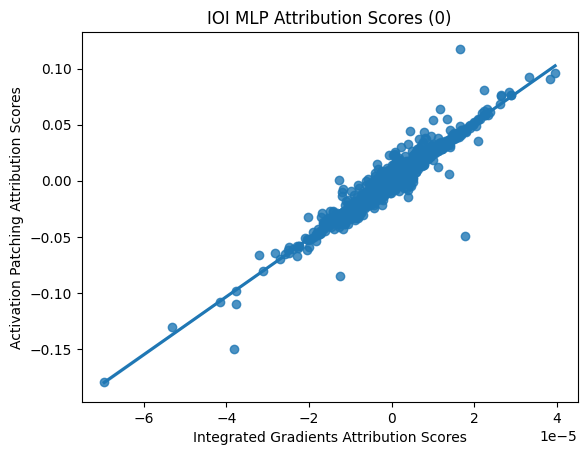

Correlation coefficient: 0.9781080432379063


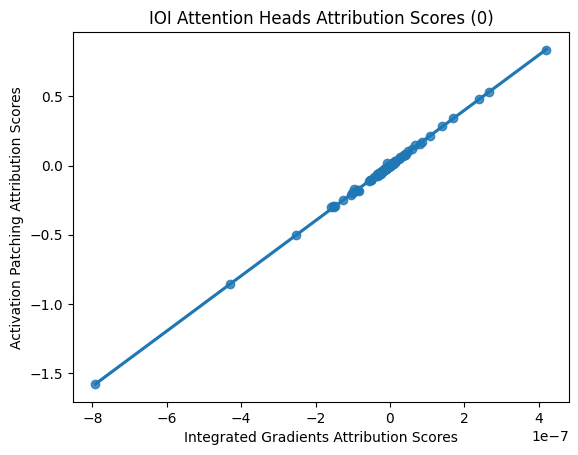

Correlation coefficient: 0.9996766516207032


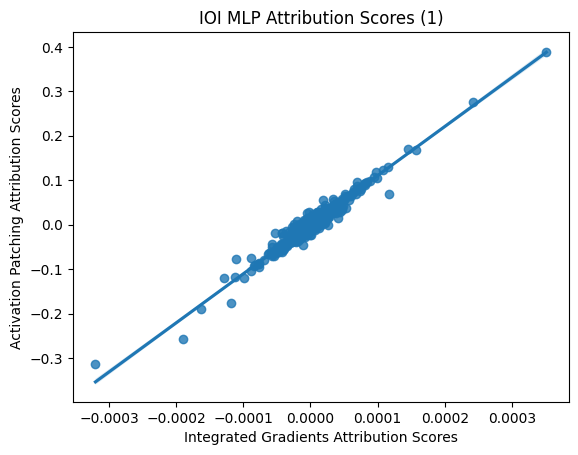

Correlation coefficient: 0.9806869213056343


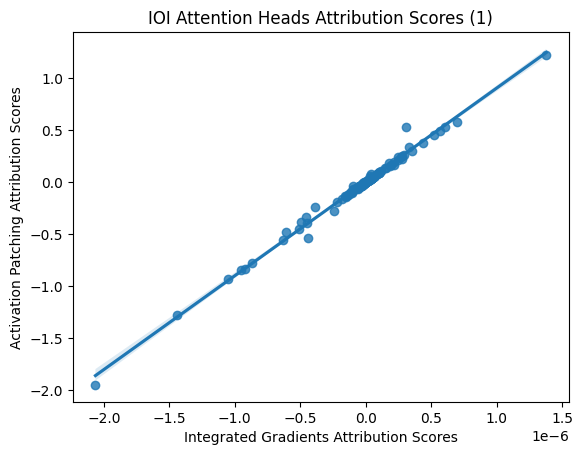

Correlation coefficient: 0.9951896346601156


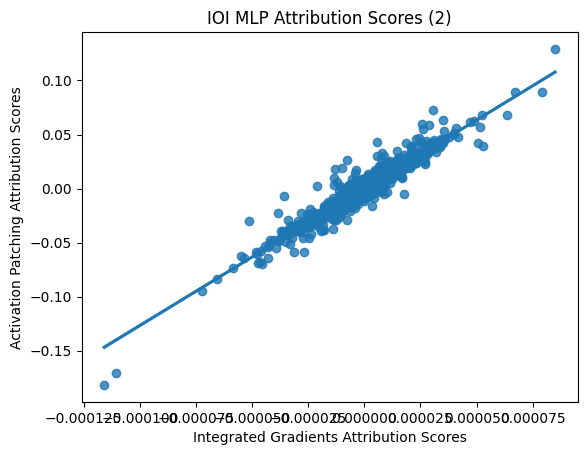

Correlation coefficient: 0.9757320351325801


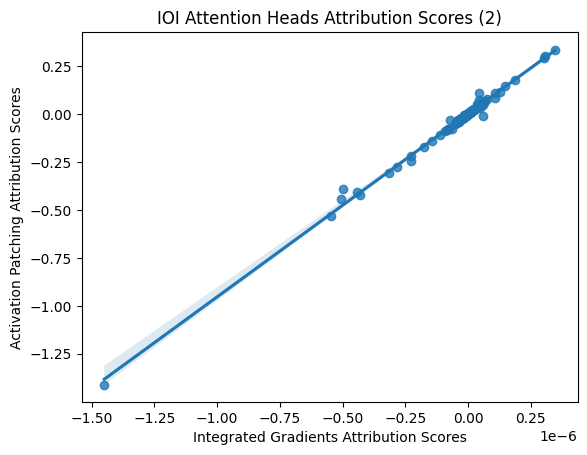

Correlation coefficient: 0.9967339347971004


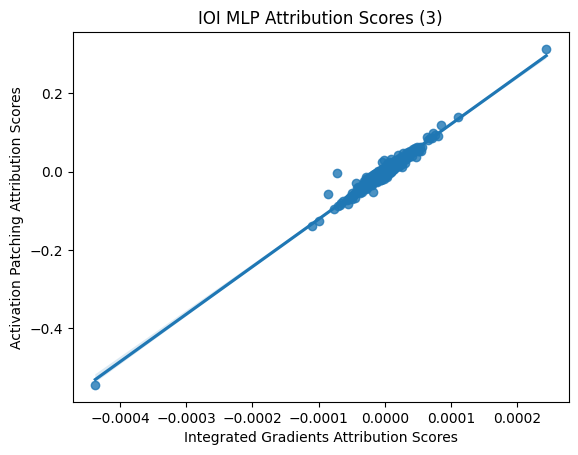

Correlation coefficient: 0.9839111524360439


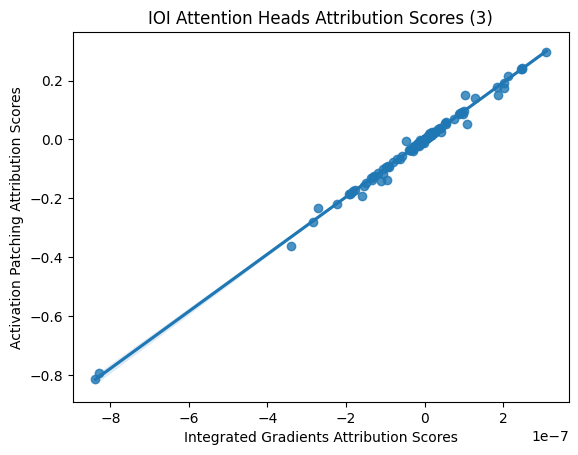

Correlation coefficient: 0.996740309786814


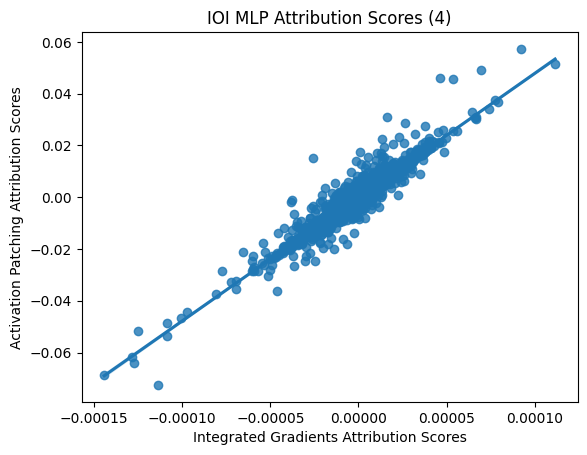

Correlation coefficient: 0.9670389804392867


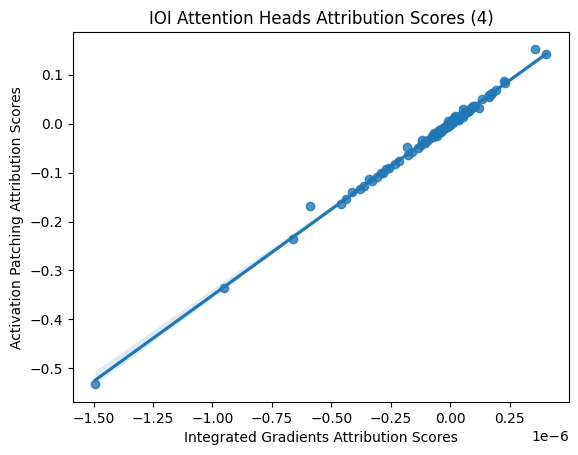

Correlation coefficient: 0.9977772050389823


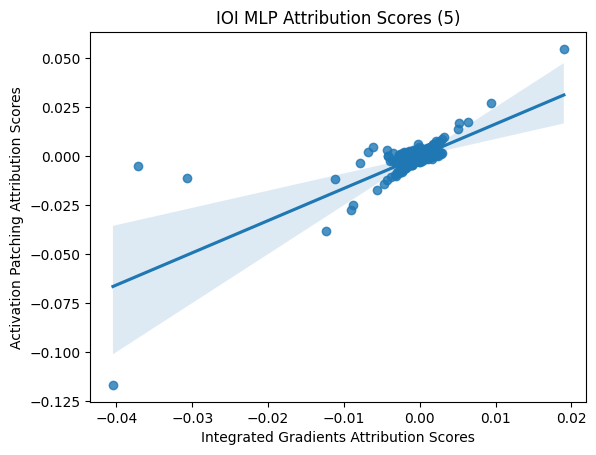

Correlation coefficient: 0.7595119716894685


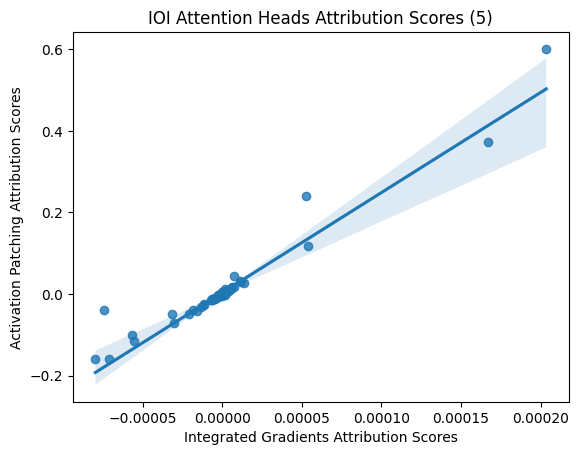

Correlation coefficient: 0.9632317618652253


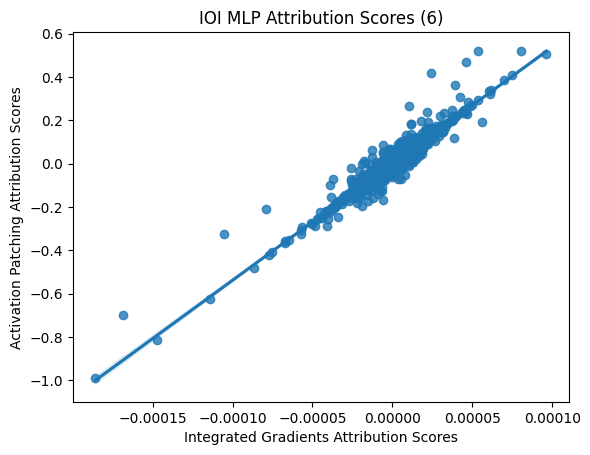

Correlation coefficient: 0.9741439049868224


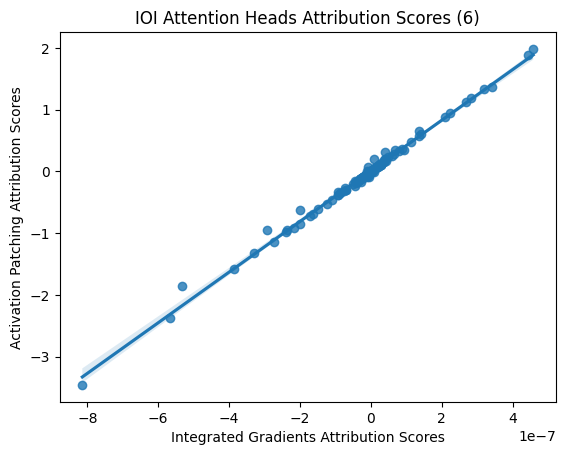

Correlation coefficient: 0.9965606146410044


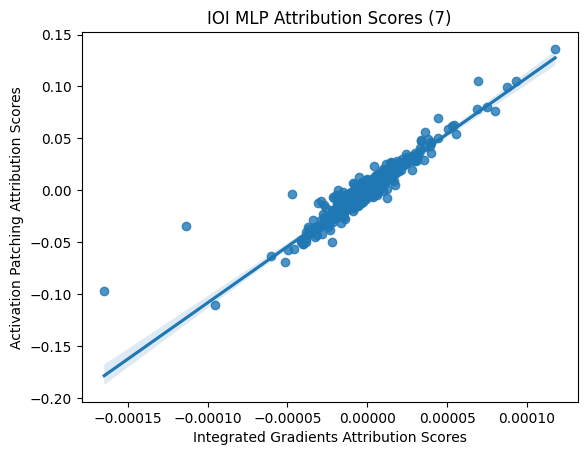

Correlation coefficient: 0.9665006578516521


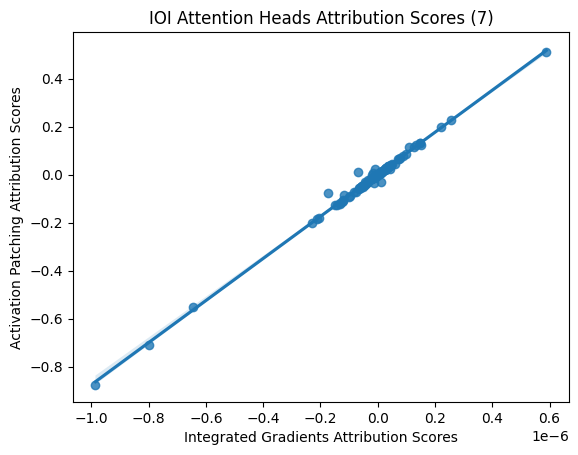

Correlation coefficient: 0.9964217666046798


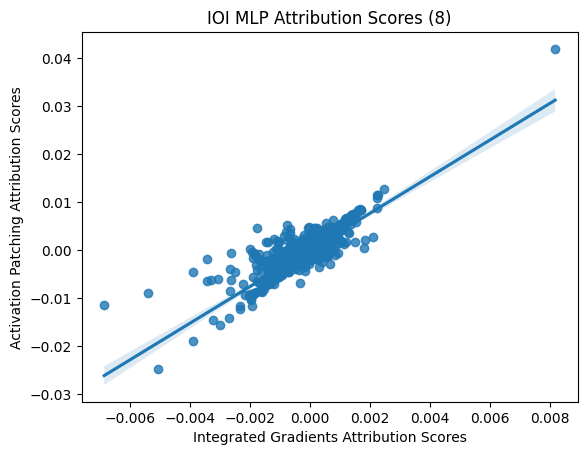

Correlation coefficient: 0.8802485907793042


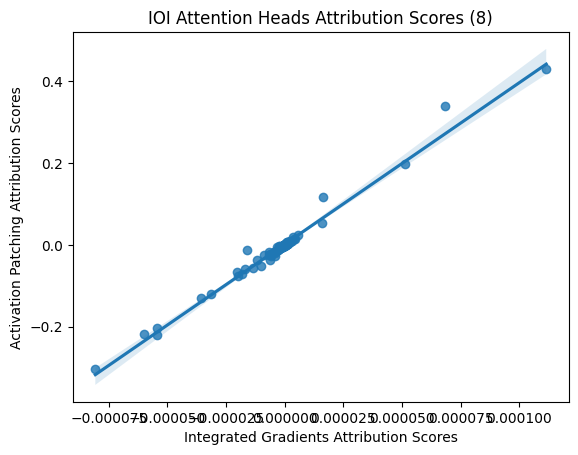

Correlation coefficient: 0.9904691632403823


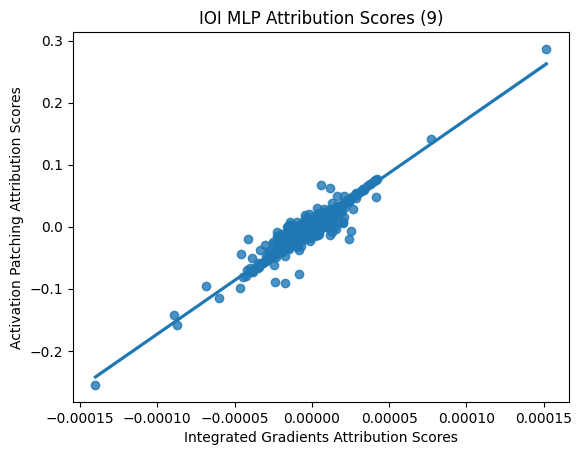

Correlation coefficient: 0.9687053829055899


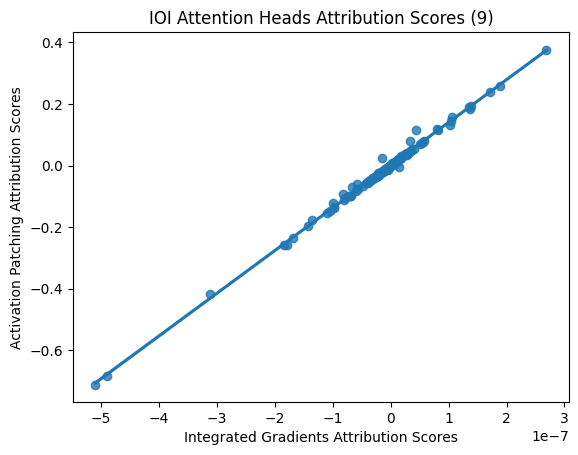

Correlation coefficient: 0.9978241411386138


In [28]:
for i in range(10):
    plot_correlation(ioi_ig_mlp[i], ioi_ap_mlp[i], f"IOI MLP Attribution Scores ({i})")
    plot_correlation(ioi_ig_attn[i], ioi_ap_attn[i], f"IOI Attention Heads Attribution Scores ({i})")

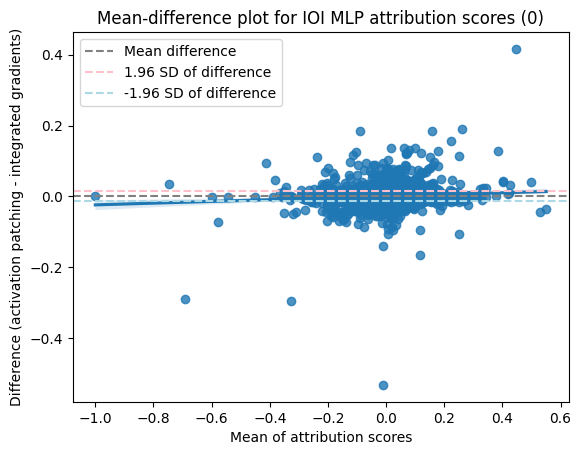

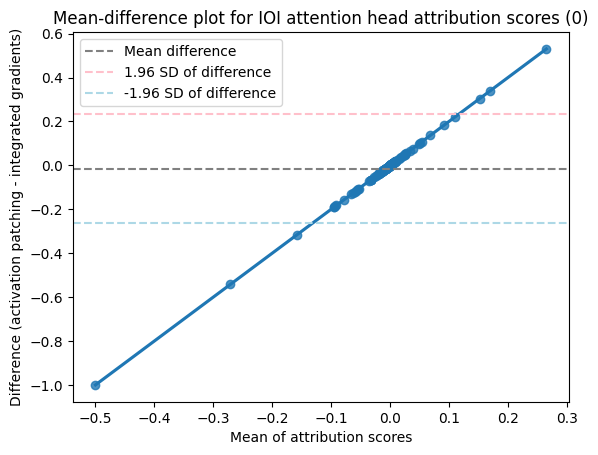

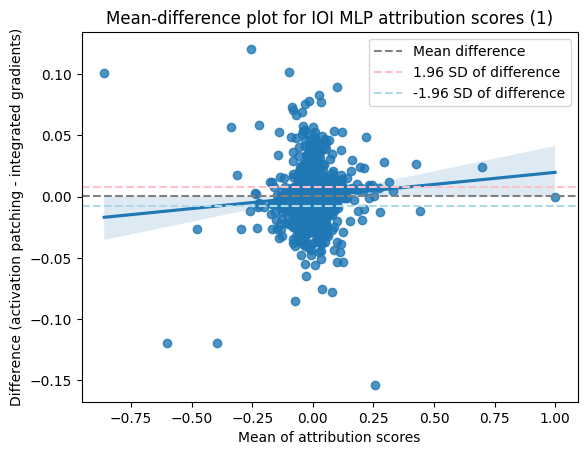

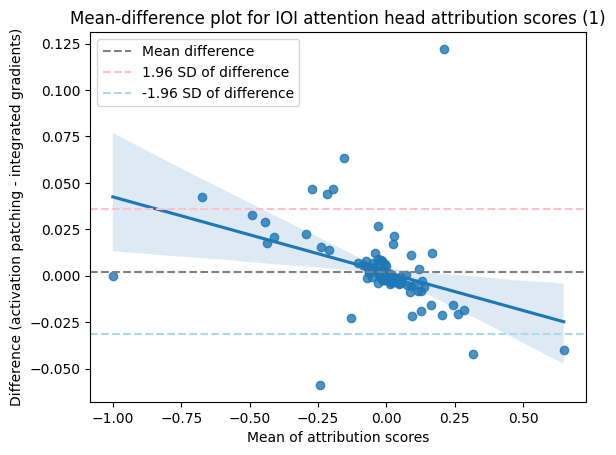

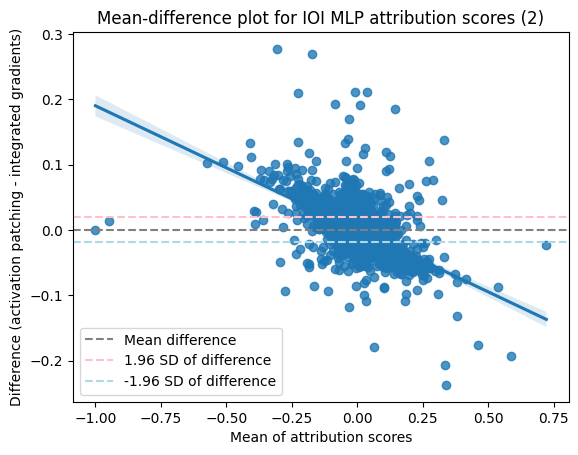

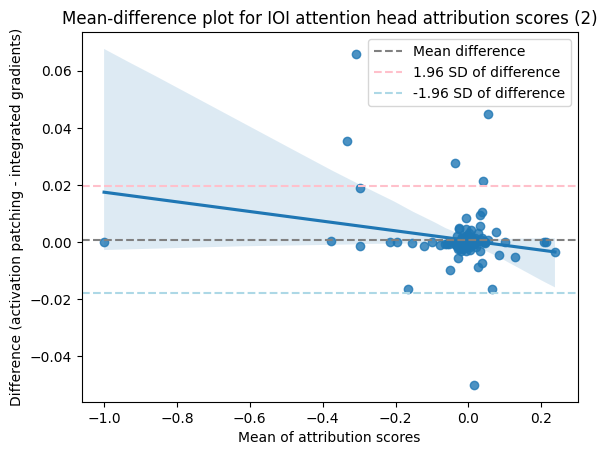

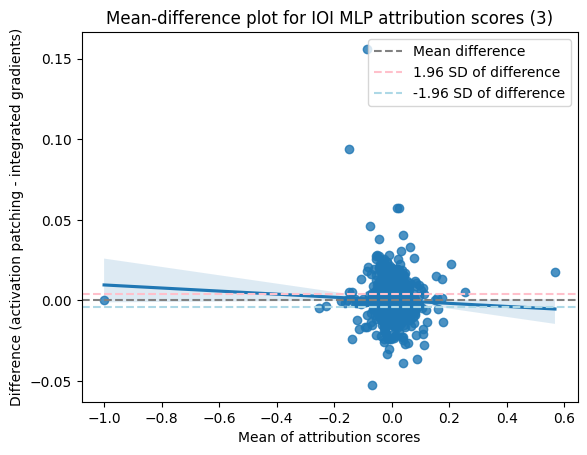

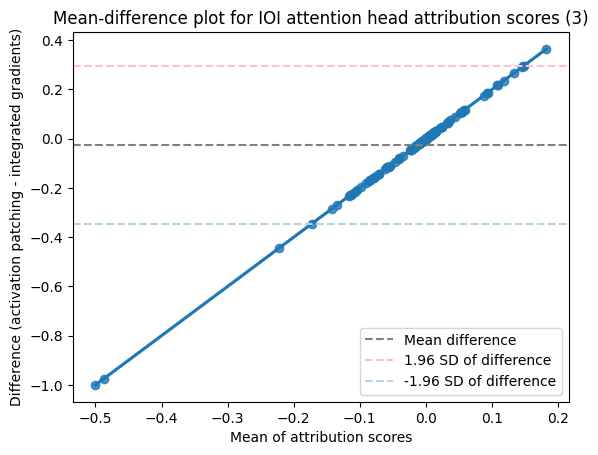

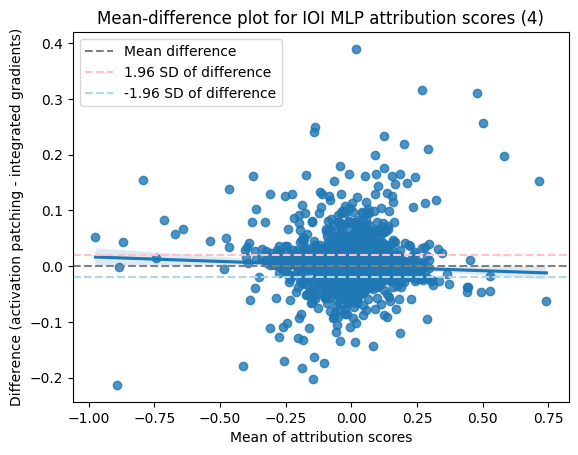

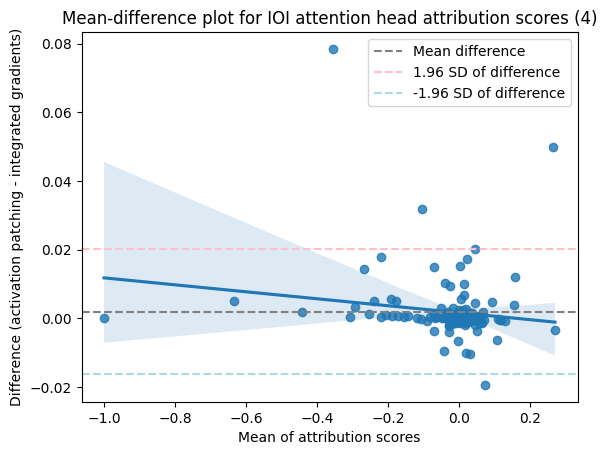

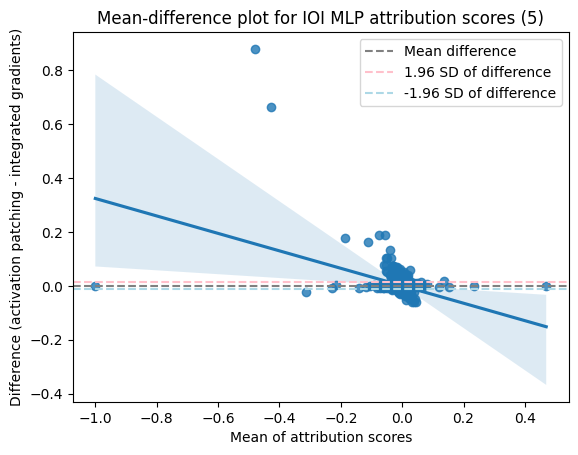

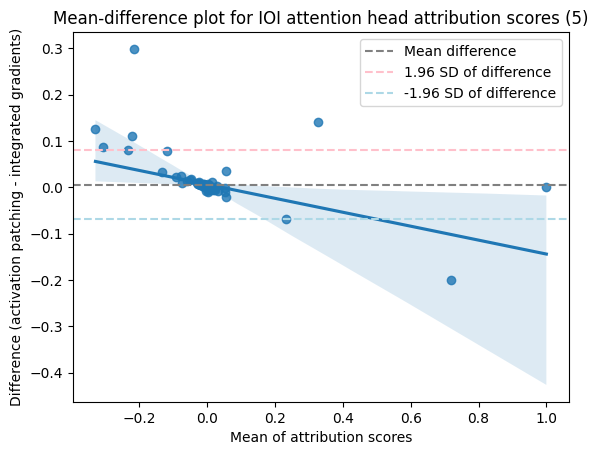

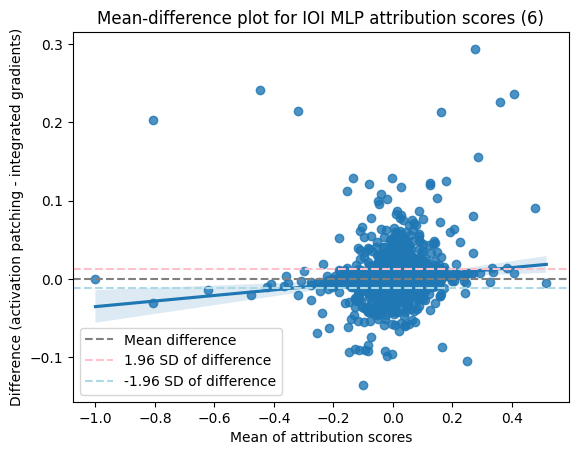

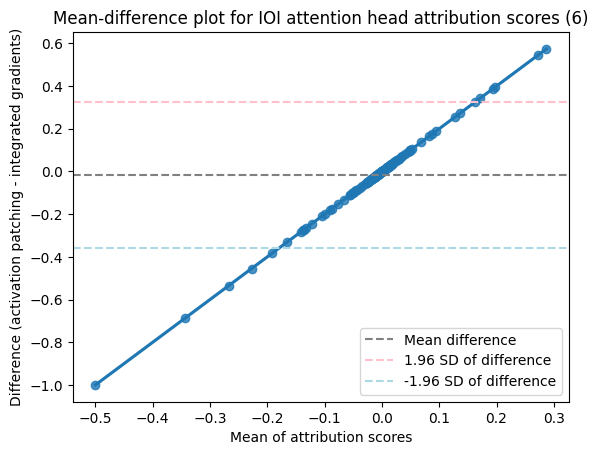

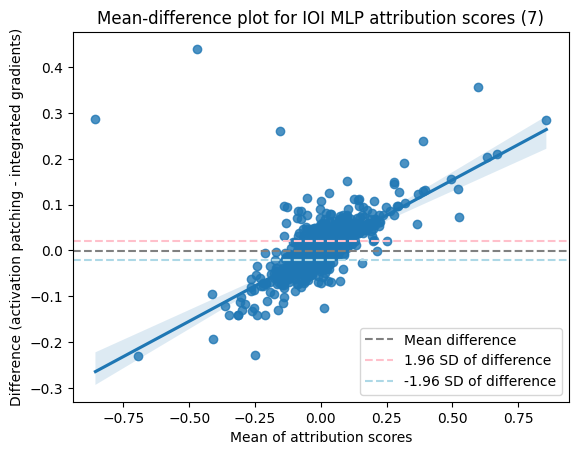

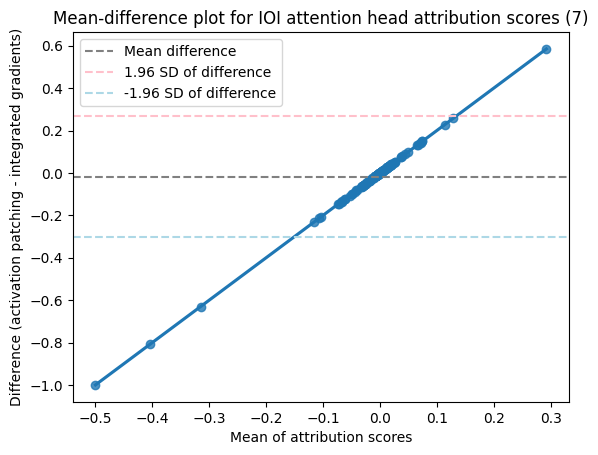

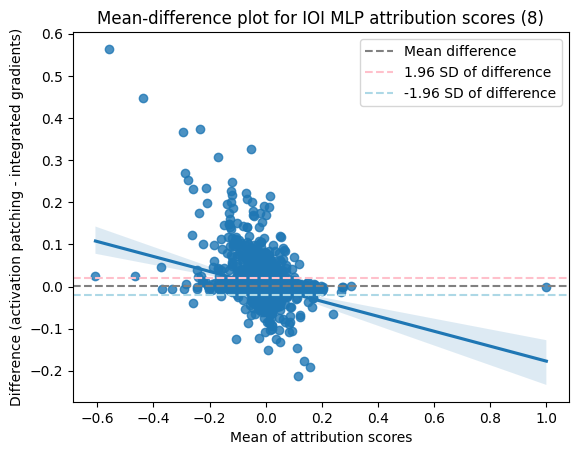

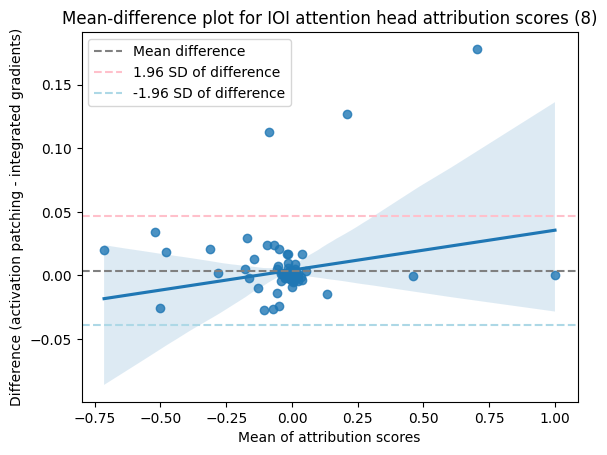

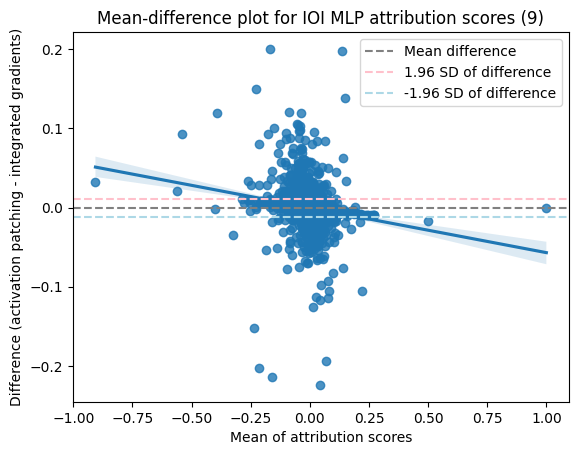

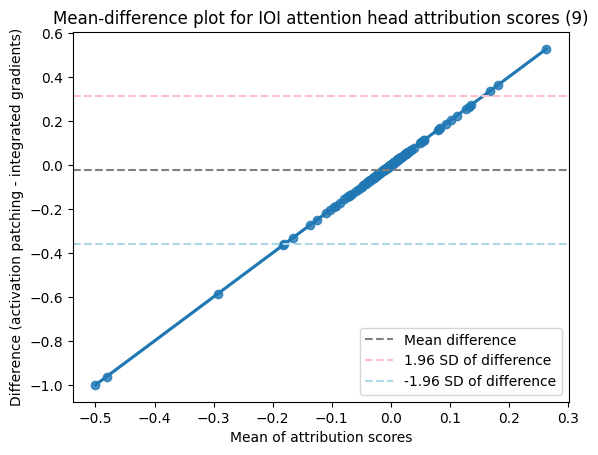

In [29]:
for i in range(10):
    plot_mean_diff(ioi_ig_mlp[i], ioi_ap_mlp[i], f"Mean-difference plot for IOI MLP attribution scores ({i})")
    plot_mean_diff(ioi_ig_attn[i], ioi_ap_attn[i], f"Mean-difference plot for IOI attention head attribution scores ({i})")

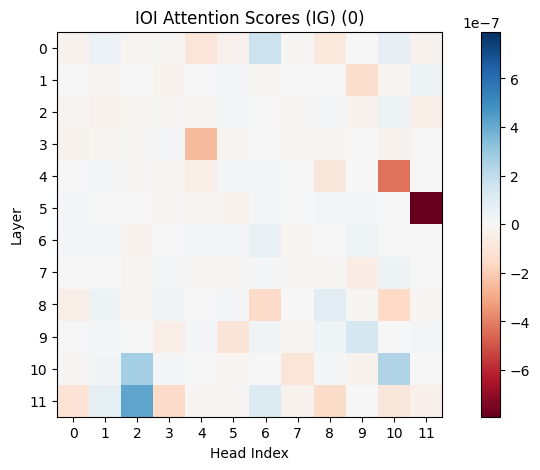

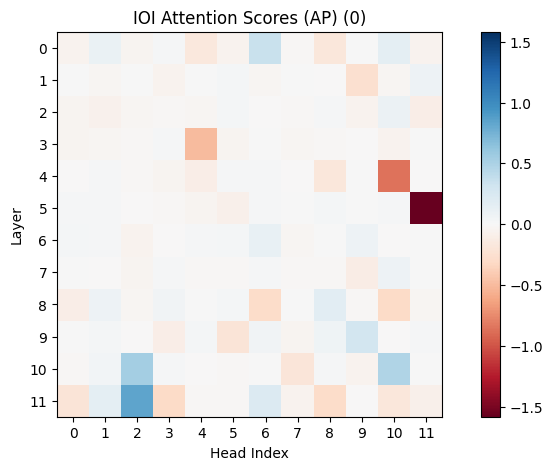

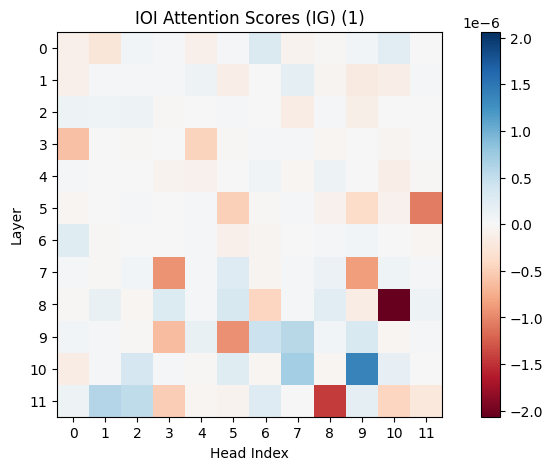

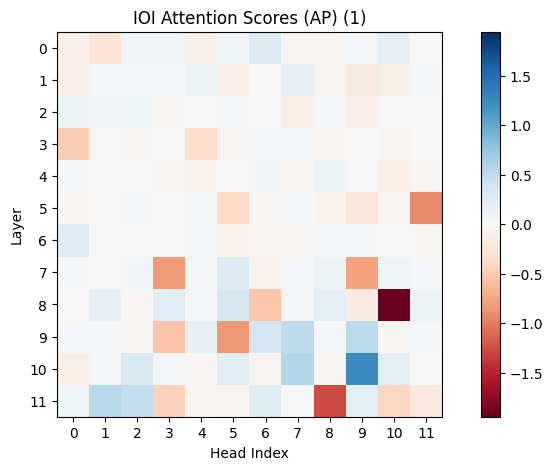

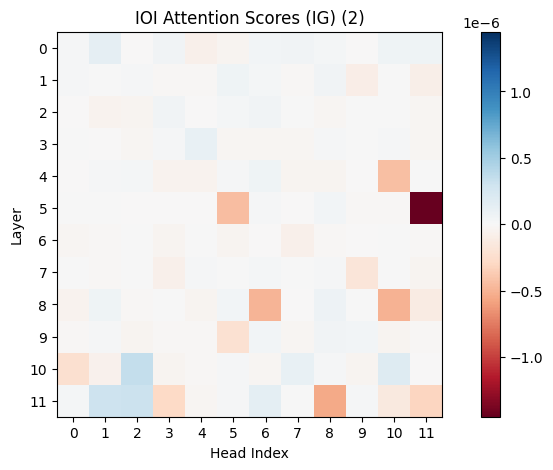

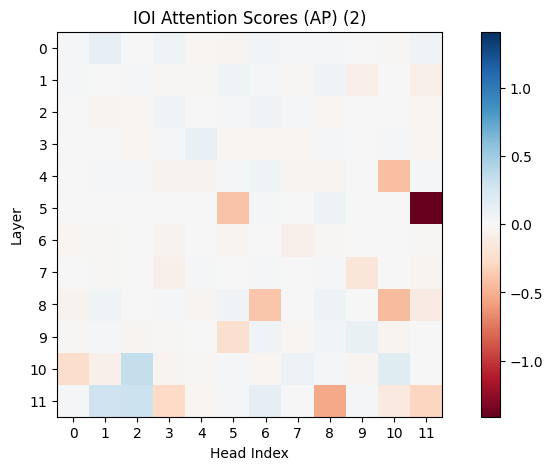

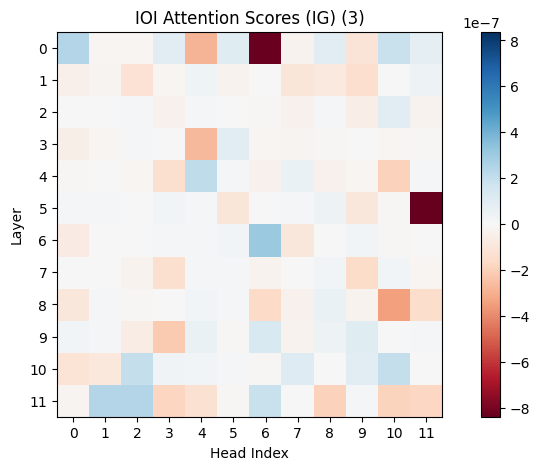

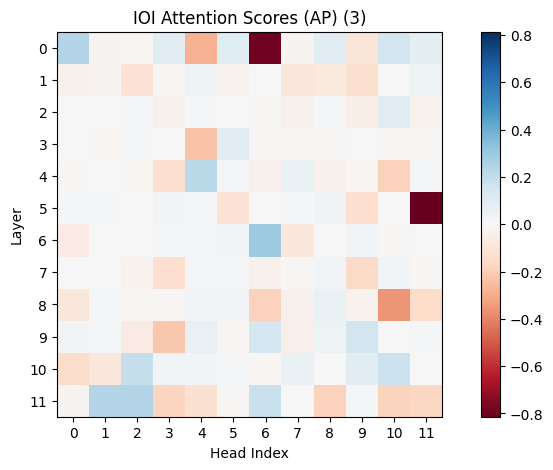

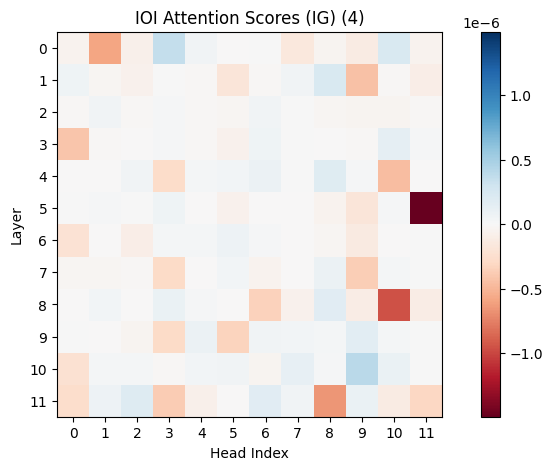

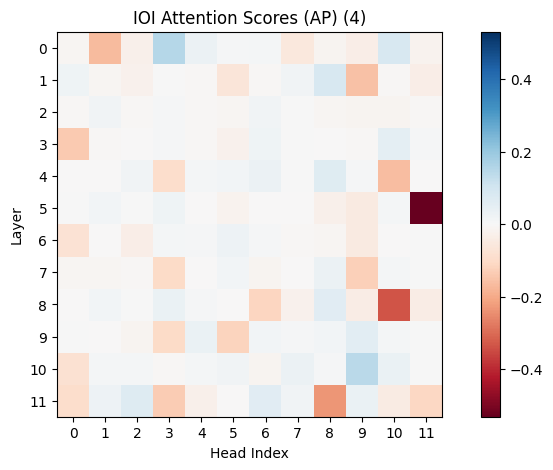

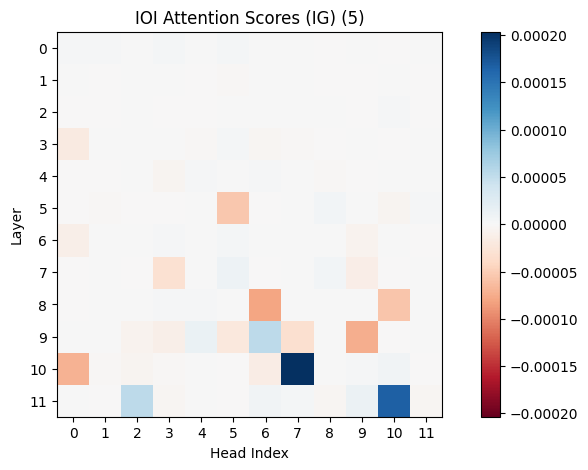

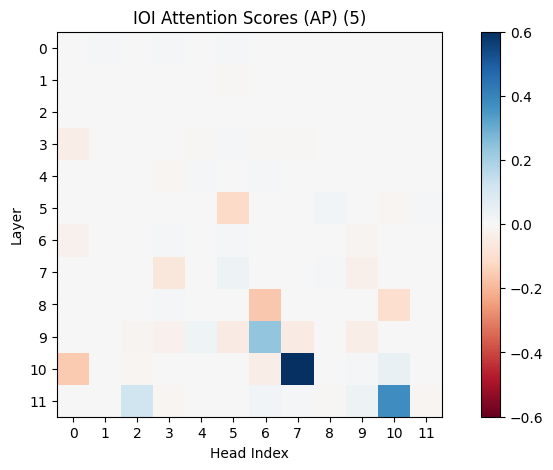

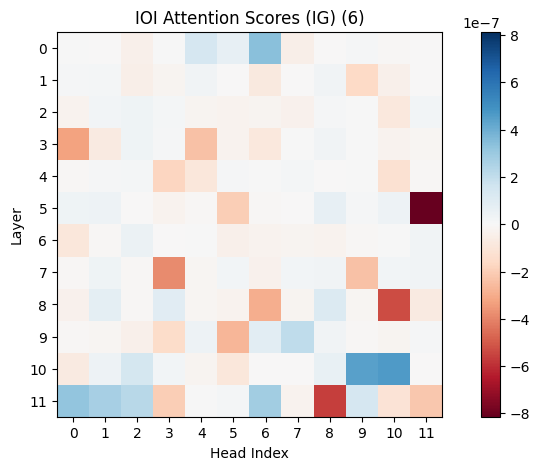

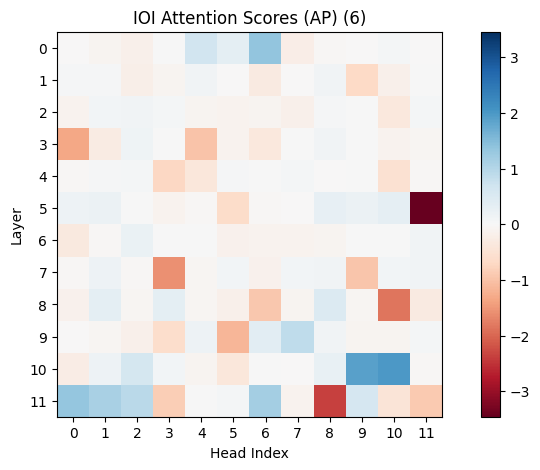

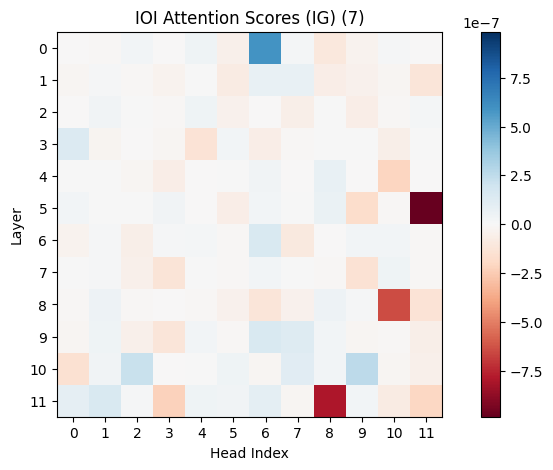

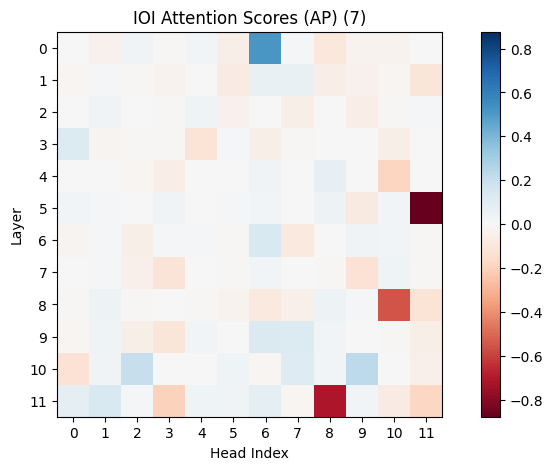

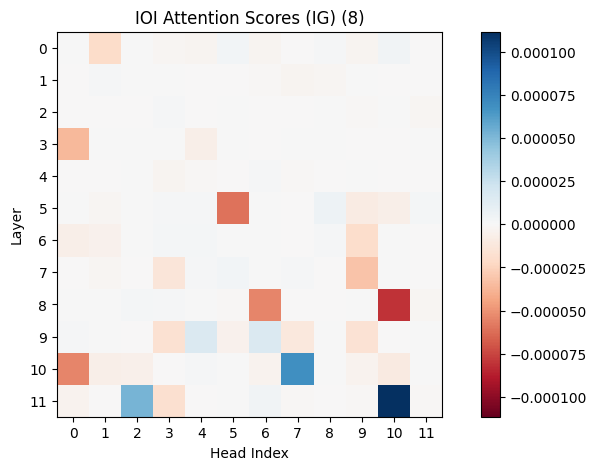

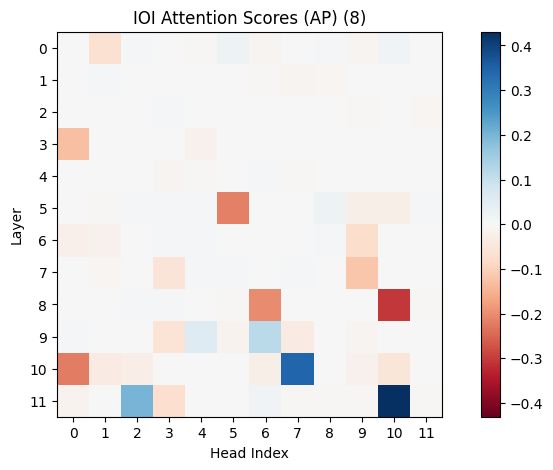

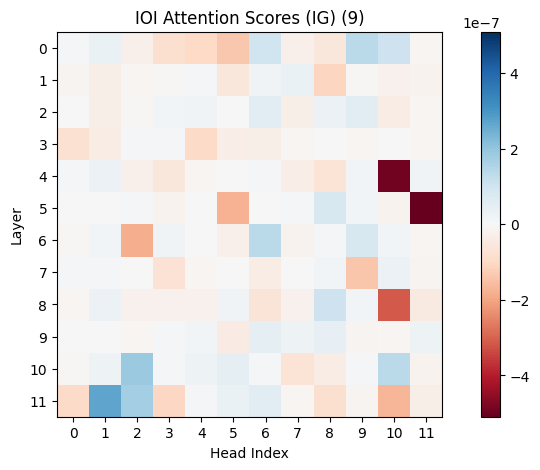

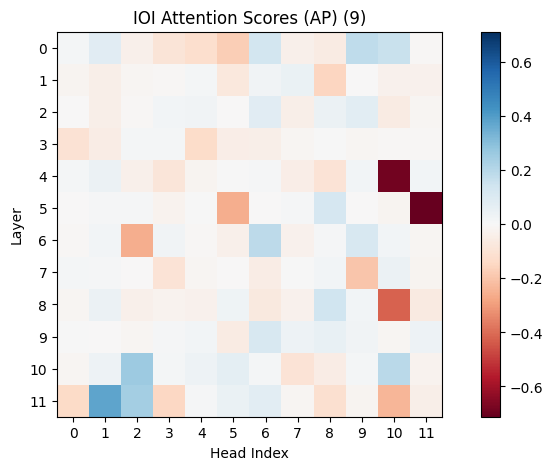

In [31]:
for i in range(10):
    plot_attn(ioi_ig_attn[i], title=f"IOI Attention Scores (IG) ({i})")
    plot_attn(ioi_ap_attn[i], title=f"IOI Attention Scores (AP) ({i})")

# Task 2: Gender Bias

In [ ]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=10)

In [ ]:
clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.4348, -1.5338,  1.4572,  1.4659,  1.4542,  1.3636,  1.4376,  1.5102,
        -1.4453,  0.6453], device='mps:0')
Corrupted logit difference: tensor([-3.9465, -1.5776,  1.1531,  1.2531,  1.2493, -4.2106,  1.3220,  1.3344,
        -1.5273, -4.0531], device='mps:0')


In [ ]:
gender_bias_ig_mlp, gender_bias_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_mlp, "saved_results/gender_bias_ig_mlp.pt")
torch.save(gender_bias_ig_attn, "saved_results/gender_bias_ig_attn.pt")

In [ ]:
gender_bias_ap_mlp, gender_bias_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(gender_bias_ap_mlp, "saved_results/gender_bias_ap_mlp.pt")
torch.save(gender_bias_ap_attn, "saved_results/gender_bias_ap_attn.pt")

In [ ]:
plot_correlation(gender_bias_ig_mlp, gender_bias_ap_mlp, "Gender bias MLP Attribution Scores")

plot_correlation(gender_bias_ig_attn, gender_bias_ap_attn, "Gender bias Attention Heads Attribution Scores")

In [ ]:
plot_mean_diff(gender_bias_ig_mlp, gender_bias_ap_mlp, "Mean-difference plot for gender bias MLP attribution scores")

plot_mean_diff(gender_bias_ig_attn, gender_bias_ap_attn, "Mean-difference plot for gender bias attention head attribution scores")

# Task 3: Greater Than

In [108]:
greater_than_dataset = TaskDataset(Task.GREATER_THAN)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=10)

In [109]:
def greater_than_prob_diff_metric(logits, correct_years):
    batch_size = logits.size(0)
    year_indices = model.to_tokens([str(year) for year in range(100)])[:, 1] # Shape [100]
    logits_last = logits[:, -1, :]
    logit_probs = torch.softmax(logits_last, dim=-1) # Shape [batch, d_vocab]
    year_probs = logit_probs[:, year_indices] # Shape [batch, 100]
    
    results = torch.zeros((batch_size))
    for i, (probs, year) in enumerate(zip(year_probs, correct_years)):
        results[i] = probs[year+1:].sum() - probs[:year+1].sum()
    
    return results

In [110]:
clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

print(clean_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

['The contract lasted from the year 1352 to the year 13', 'The plan lasted from the year 1642 to the year 16', 'The plan lasted from the year 1457 to the year 14', 'The marriage lasted from the year 1783 to the year 17', 'The campaign lasted from the year 1388 to the year 13', 'The progress lasted from the year 1491 to the year 14', 'The study lasted from the year 1727 to the year 17', 'The case lasted from the year 1655 to the year 16', 'The fall lasted from the year 1375 to the year 13', 'The progress lasted from the year 1535 to the year 15']
Clean logit difference: tensor([0.8690, 0.9025, 0.9068, 0.8934, 0.8278, 0.8116, 0.9455, 0.8799, 0.7257,
        0.9022])
Corrupted logit difference: tensor([-0.4874, -0.3821, -0.4345, -0.6994, -0.8329, -0.5399,  0.0454, -0.4602,
        -0.7457, -0.3863])


In [111]:
greater_than_ig_mlp, greater_than_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ig_mlp, "saved_results/greater_than_ig_mlp.pt")
torch.save(greater_than_ig_attn, "saved_results/greater_than_ig_attn.pt")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [ ]:
greater_than_ap_mlp, greater_than_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(greater_than_ap_mlp, "saved_results/greater_than_ap_mlp.pt")
torch.save(greater_than_ap_attn, "saved_results/greater_than_ap_attn.pt")

# Task 4: Capital Country

In [115]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=10)

In [116]:
clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.8200, -2.5300, -2.0190,  6.3455, -0.5265,  0.9513,  0.8347, -1.4007,
         2.1496, -3.0366], device='mps:0')
Corrupted logit difference: tensor([-1.8150, -2.5942, -2.0515,  0.9749, -0.7268,  0.7562,  0.4618, -1.4402,
         2.0016, -3.2090], device='mps:0')


In [ ]:
capital_country_ig_mlp, capital_country_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_mlp, "saved_results/capital_country_ig_mlp.pt")
torch.save(capital_country_ig_attn, "saved_results/capital_country_ig_attn.pt")

In [ ]:
capital_country_ap_mlp, capital_country_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(capital_country_ap_mlp, "saved_results/capital_country_ap_mlp.pt")
torch.save(capital_country_ap_attn, "saved_results/capital_country_ap_attn.pt")